# **Breast Cancer Classification with a Neural Network**

**Goal:** Use a neural network to classify breast cancer diagnoses in a dataset. Explore how adjusting the number of layers and neurons per layer affects model performance. This expands a project in the IBM AI Engineering Professional Certificate offered through Coursera.

In [9]:
'''
For this segment of the project I will use PyTorch to build and train my neural network.
Begin by installing all the required packages.
'''

%pip install pandas==2.2.2
%pip install numpy==1.26.4
%pip install matplotlib==3.8.0
%pip install scikit-learn==1.5.0
%pip install torch==2.3.1
%pip install ucimlrepo==0.0.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 754.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [10]:
'''
Now I'll load all the required packages.
'''

from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

**Load and Process the Dataset.**

The dataset we'll use is the [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) dataset. It contains 539 samples, each with 30 features. Each data point is labelled as 'benign' or 'malignant'. The goal is to use the features to predict the diagnosis.

This dataset is free to use and is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

In [11]:
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# concatenate these into a common pandas dataframe for easier manipulation
df = pd.concat([X,y], axis = 1)

# check how many of each diagnosis there is
df.value_counts('Diagnosis')

,count
Diagnosis,
B,357
M,212


We note that there are considerably more benign examples than malignant, and we don't want this asymmetry to influence our classifier. We'll split the data into malignant and benign, and randomly sample 212 benign samples to balance the dataset.



In [12]:
# split the dataset into the two diagnoses
df_M = df[df['Diagnosis'] == 'M']
df_B = df[df['Diagnosis'] == 'B']

# sample 212 malignant samples
df_B = df_B.sample(n = 212, random_state = 42)

# rejoin the dataset
df_balanced = pd.concat([df_M, df_B])

# check to see that we have the correct value counts
df_balanced.value_counts('Diagnosis')

,count
Diagnosis,
B,212
M,212


**Data Preprocessing**

Now that we've balanced our dataset, we'll split it into features and targets and convert the targets into binary labels. We'll then split the data into training, validating, and testing data. We'll use 70% for training, 15% for validating, and 15% for testing.

In [13]:
# extract the features and targets
X = df_balanced.drop('Diagnosis', axis = 1)
y = df_balanced['Diagnosis']

# convert the targets to binary labels
y = y.map({'B':0, 'M':1})


# split into 70% training, 15% validating, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size = 0.3, stratify = y, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

display(f'X_train shape: {X_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {X_test.shape}')
display(f'y_test shape: {y_test.shape}')
display(f'X_val shape: {X_val.shape}')
display(f'y_val shape: {y_val.shape}')

'X_train shape: (296, 30)'

'y_train shape: (296,)'

'X_test shape: (64, 30)'

'y_test shape: (64,)'

'X_val shape: (64, 30)'

'y_val shape: (64,)'

Now that this is done, we'll use `StandardScaler`, fit to the training data, to normalize the training, validation, and testing data; note that fitting the scaler to the training prevents information about the validation or testing data affecting the training process. After that, we'll convert everything into a Tensor to get it ready for the neural network.

In [14]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_val = torch.tensor(y_val.values, dtype = torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = False)

**Define the Model**

Now we're going to initialize the model. I want to tune both the number of layers and the number of neurons in each layer later on, so I'll use a for loop to define each layer and recursively define the forward pass. We'll use ReLU as our activiation function (this could be tuned later on, if we want).

In [55]:
class ClassifierNet(nn.Module):

    # Constructor
    # Given a list of integers, Layers, we create layers of the neural network where each integer in Layers corresponds to the layers number of neurons
    def __init__(self, Layers):
        super(ClassifierNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.dropout = nn.ModuleList()  # To store dropout layers

        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            self.dropout.append(nn.Dropout(0.2))

    # Prediction
    # Puts the X value through each layer of the neural network while using the RELU activation function in between. The final output is not put through RELU.
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = F.relu(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

**Define the Training Function**

Since we want to tune the number of epochs, layers, and neurons per layer, we'll define a training function to employ in a loop.

In [56]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
      # Training phase
      model.train()
      running_loss = 0.0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      train_loss = running_loss / len(train_loader)
      train_losses.append(train_loss)

      # Evaluation phase on test set
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for X_batch, y_batch in val_loader:
              val_outputs = model(X_batch)
              loss = criterion(val_outputs, y_batch)
              val_loss += loss.item()

      val_loss /= len(val_loader)
      val_losses.append(val_loss)

  return train_losses, val_losses

**Train the Model**

Now I'm going to train the model. The point of the project is to practice tuning how many layers and neurons are in the neural network, so that's why I've set it up the way I have. I'm setting a dictionary where the keys represent the number of layers and the values are arrays containing the number of neurons per layer. In order to find the best option, I'll iterate over this to find the best hyper-parameters.

In [63]:
# create a dictionary with the keys representing the number of neurons in each layer
in_features = X_test.shape[1]
out_features = 2

layer_options = {
    1:[[in_features, 32, out_features],
      [in_features, 64, out_features],
      [in_features, 128, out_features],
       [in_features, 256, out_features],
       [in_features, 512, out_features]],
    2:[[in_features, 32, 64, out_features],
      [in_features, 32, 128, out_features],
      [in_features, 64,32, out_features],
       [in_features, 32,32, out_features],
       [in_features, 16,16, out_features]],
    3:[[in_features, 32, 64, 32, out_features],
      [in_features, 64, 128, 32, out_features],
      [in_features, 32, 32, 64, out_features],
       [in_features, 16, 32, 32, out_features],
       [in_features, 32, 32, 32, out_features]],
    4:[[in_features, 32, 64, 32, 32, out_features],
      [in_features, 64, 128, 32, 64, out_features],
      [in_features, 32, 32, 64, 32, out_features],
       [in_features, 16, 32, 32, 16, out_features],
       [in_features, 32, 32, 64, 64, out_features]],
    5:[[in_features, 32, 64, 32, 64, 54, out_features],
      [in_features, 64, 128, 32, 128, 64, out_features],
      [in_features, 32, 32, 64, 64, 64, out_features],
       [in_features, 16, 32, 32, 128, 64, out_features],
       [in_features, 32, 32, 32, 32, 32, out_features]]
}

#start the training loop
num_epochs = 30
results = []

for option in layer_options:
  for i in range(len(layer_options[option])):
    num_layers = len(layer_options[option][0])
    num_neurons = layer_options[option][i]

    model = ClassifierNet(layer_options[option][i])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    temp_results = [num_layers, num_neurons, train_losses, val_losses]
    results.append(temp_results)

**Visulaize Results**

Now that we have some data about the training process, we can plot to results and figure out the best parameters for the model.

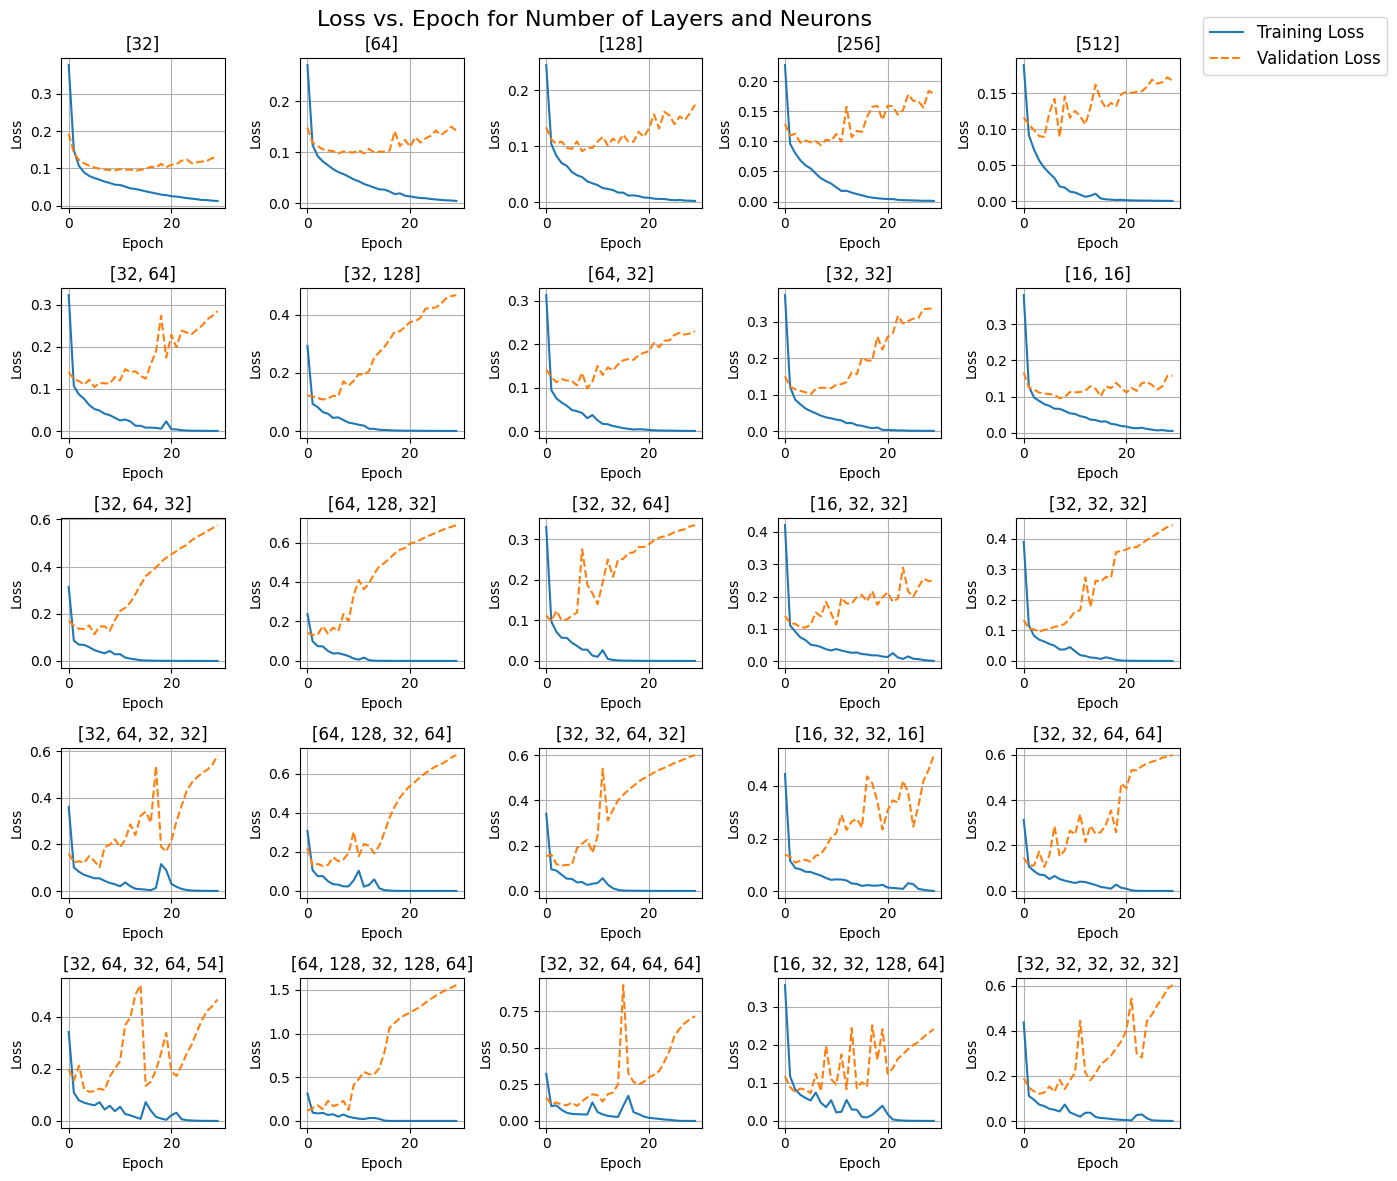

In [64]:
#helper function to plot the result from the tuning loop
def plot_grid(x, titles, y_list, z_list):
    # Determine the size of the grid (n x n)
    n = int(len(y_list) ** 0.5)  # We assume the number of y arrays is a perfect square (n^2)

    # Create a grid of subplots
    fig, axes = plt.subplots(n, n, figsize=(12, 12))  # n x n grid, adjust figsize as needed

    # Flatten the axes array to iterate over it easily
    axes = axes.flatten()

    plot_list = zip(titles, y_list, z_list)
    # Loop through the y_list and plot each y_i against x
    for i, y in enumerate(plot_list):
        ax = axes[i]
        ax.plot(x, y[1])
        ax.plot(x, y[2], linestyle = '--') # Plot x vs y_i
        ax.set_title(f"{y[0][1:-1]}")  # Title for each subplot
        ax.grid(True)  # Add grid for readability
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')


    fig.legend(['Training Loss', 'Validation Loss'], loc='center left', bbox_to_anchor=(1, 0.95), fontsize=12)

    fig.suptitle('Loss vs. Epoch for Number of Layers and Neurons', fontsize=16)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    #plt.title('Loss vs. Epoch for Numbers of Layers and Neurons')
    plt.show()


x = np.arange(num_epochs)  # number of epochs values
titles = [results[i][1] for i in range(25)]
train_losses = [results[i][2] for i in range(25)]
val_losses = [results[i][3] for i in range(25)]

# Plot the results
plot_grid(x, titles, train_losses, val_losses)


We see that there is a clear trend of over-fitting on the dataset. This is not so surprising because it is somewhat small. Next step is to identify the optimal parameters.

In [66]:
#helper function to find the minimum value and its index of an array
def min_value(arr):
  min_index_flat = np.argmin(arr)
  min_index_2d = np.unravel_index(min_index_flat, arr.shape)
  min_value = arr[min_index_2d]

  return min_value, min_index_2d

# find the model paramters giving the best result.
val_results_stack = np.vstack(val_losses)
min_value, min_index_2d = min_value(val_results_stack)

#print the results
print(f'''The model that performed best on the validation set had {results[min_index_2d[0]][0]-2} layers with {results[min_index_2d[0]][1][1:-1]} neurons,
training for {min_index_2d[1]+1} epochs. The loss was {min_value}.''')

The model that performed best on the validation set had 5 layers with [16, 32, 32, 128, 64] neurons,
training for 6 epochs. The loss was 0.07273447829065027.


**Evaluation**

Now I'm going to test my model using the test set. Since the application is cancer screening, I'm going to see what its *recall* is: a recall value close to 1 means that we have a small number of false negatives, whereas a recall value close to zero means we have many more false negatives than true positives.

In [68]:
# define the model
best_model = ClassifierNet(results[min_index_2d[0]][1])

#train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

_, _ = train_model(model, train_loader, val_loader, criterion, optimizer, 6)

In [81]:
from sklearn.metrics import classification_report

y_pred = model(X_test)
y_pred = torch.argmax(y_pred, dim=1).numpy()

#get my classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.97      0.99        35

    accuracy                           0.98        64
   macro avg       0.98      0.99      0.98        64
weighted avg       0.98      0.98      0.98        64



**Conclusion**

Overall, I think we did fairly well! A recall of 0.97 and an overall accuracy of 98% is quite good. Some things to consider in the future would be investigating how the drop-out rate affects the overfitting. Also, since this is a diagnostic type of problem, we could change our loss function to be the recall of the model and minimize that. In each instance the loss converged to zero, so I don't think changing the optimizer and the associated the parametres would make much of a difference.